In [2]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

%matplotlib inline
%config IPCompleter.greedy=True
plt.rcParams["figure.figsize"] = (14, 8)

    N  T  MSE  STD
0  54  1  0.0  0.0
1  36  4  0.0  0.0
2  52  3  0.0  0.0
3  46  3  0.0  0.0
4  81  2  0.0  0.0
5  61  4  0.0  0.0
6  59  0  0.0  0.0
7  51  1  0.0  0.0
8   1  4  0.0  0.0
9  58  0  0.0  0.0
{'T_Max': 5, 'N_Max': 100, 'reps': 2, 'epochs': 10, 'Y': 'ch4_flux', 'proc': 1}


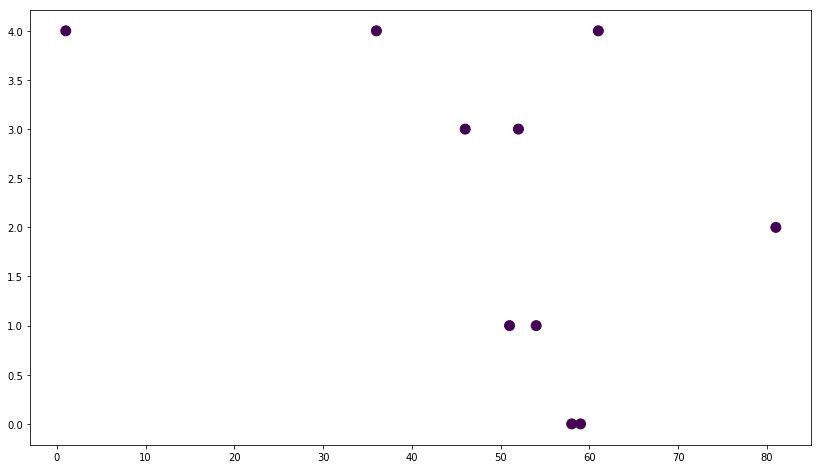

In [19]:
class Params:
    def __init__(self,Func,samp_size,Y):
        if Func == 'Quick':            
            epochs = 1000
            reps = 10
            N_Max = 300
            T_Max = 6
        elif Func == 'Full':
            epochs = 2000
            reps = 100
            N_Max = 200
            T_Max = 12
        else:
            epochs = 10
            reps = 2
            N_Max = 100
            T_Max = 5
        N = np.array(np.random.rand(samp_size)*N_Max,dtype='int32')
        T = np.array(np.random.rand(samp_size)*T_Max,dtype='int32')
        d = {'N':N,'T':T}
        self.Runs = pd.DataFrame(data=d)
        self.params = {}
        self.params['T_Max'] = T_Max
        self.params['N_Max'] = N_Max
        self.params['reps'] = reps
        self.params['epochs'] = epochs
        self.params['Y'] = Y
        self.params['proc']=1

rpms = Params('Short',10,'ch4_flux')
Runs,params = rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
print(Runs)
print(params)
plt.figure()
plt.scatter(Runs["N"],Runs['T'],s=100,c=Runs['MSE'])

In [20]:
class ReadStandardTime:
    def __init__(self,Path):
        self.Master = pd.read_csv(Path,delimiter = ',',header = 0,na_values = -9999)
        self.Master = self.Master.set_index(pd.DatetimeIndex(pd.to_datetime(self.Master['datetime'])))
        self.Master['DOY'] = self.Master.index.dayofyear*1.0
        self.Master['HR'] = self.Master.index.hour*1.0
        
    def Scale(self,y_var,X_vars):
        self.y_var = y_var
        self.Data = self.Master[np.isfinite(self.Master[y_var])]
        self.Data = self.Data.interpolate().bfill()
        self.Data = self.Data.interpolate().ffill()
        self.y = self.Data[y_var].values
        YStandard = StandardScaler()
        self.YScaled = YStandard.fit(self.y.reshape(-1, 1))
        Yscale = self.YScaled.transform(self.y.reshape(-1, 1))
        self.y = np.ndarray.flatten(Yscale)
        self.Ytru = self.YScaled.inverse_transform(self.y.reshape(-1,1))
        X = self.Data[X_vars]
        self.input_shape = len(X_vars)
        XStandard = StandardScaler()
        self.XScaled= XStandard.fit(X)
        self.X = self.XScaled.transform(X)
        Filling = self.Master[X_vars]
        Filling = Filling.interpolate().bfill()
        Filling = Filling.interpolate().ffill()
        XStandard = StandardScaler()
        self.XFillScaled= XStandard.fit(Filling)
        self.X_fill = self.XScaled.transform(Filling)
        
    def TimeShape(self,rolls):
        X1 = self.X
        Xf = self.X_fill
        self.X_time = np.zeros(shape = (X1.shape[0],rolls+1,X1.shape[1]))
        self.X_time[:,0,:] = X1
        self.X_ftime = np.zeros(shape = (Xf.shape[0],rolls+1,Xf.shape[1]))
        self.X_ftime[:,0,:] = Xf
        if rolls > 0:
            for roll in range(0,rolls):
                X2 = np.roll(X1,(roll+1),axis=0)
                X2f = np.roll(Xf,(roll+1),axis=0)
                self.X_time[:,roll+1,:] = X2
                self.X_ftime[:,roll+1,:] = Xf
        self.X_time = self.X_time[rolls+1:,:,:]
        self.X_ftime = self.X_ftime[rolls+1:,:,:]
        self.y_time = self.y[rolls+1:]
        self.y_ftime = self.y[rolls+1:]
        self.TimeSteps = rolls+1
        
    def Fill(self,Y_Pred):
        Y_fill = self.YScaled.inverse_transform(Y_Pred.reshape(-1,1))
        nanz = np.zeros(shape=(self.TimeSteps,1))
        nanz[:,:] = np.nan
        Y_Pred = np.concatenate((nanz,Y_fill),axis=0).reshape(-1,1)
        self.Master['TempFIll'] = Y_Pred
        self.Master[self.y_var+'_Filled'] = self.Master[self.y_var].fillna(self.Master['TempFIll'])

In [21]:
def LSTM_Model(Neurons,batch_size,time_steps,inputs,lr=1e-4,Memory=.9):
    import keras
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import LSTM
    from keras.wrappers.scikit_learn import KerasRegressor
    from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
#     from keras import backend as K
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = Memory
    session = tf.Session(config=config)
    model = Sequential()
    model.add(LSTM(Neurons, input_shape=(time_steps,inputs),stateful = False))
    model.add(Dense(1))
    NUM_GPU = 1 # or the number of GPUs available on your machine
    
    adam = keras.optimizers.Adam(lr = lr)
    gpu_list = []
    for i in range(NUM_GPU): gpu_list.append('gpu(%d)' % i)
    model.compile(loss='mean_squared_error', optimizer='adam')#,context=gpu_list) # - Add if using MXNET
    return(model)

def Train_Steps(epochs,Neurons,X_train,X_test,X_val,y_train,y_test,y_val,i,Memory=None):
    
    np.random.seed(i)
    from keras import backend as K
#     epochs = 100
    Scorez=[]
    lr = 1e-3
    Mod = LSTM_Model(Neurons,X_train.shape[0],X_train.shape[1],X_train.shape[2],lr=lr,Memory=Memory)
    killscore=0
    killmax = 10
    e = 0
    udate = 3
    while killscore < killmax and e < epochs:
        Mod.fit(X_train,y_train,batch_size=X_train.shape[0], nb_epoch=1,shuffle=True,verbose=0)
        old_weights = Mod.get_weights()
        Y = Mod.predict(X_test,batch_size =X_test.shape[0])
        score = metrics.mean_squared_error(y_test,Y)
        Scorez.append(score)
        if e == 0:
            score_min=score
            min_weights=old_weights
        elif score < score_min:
            score_min = score
            min_weights=old_weights
            killscore = 0
        else:
            killscore +=1
        if killscore == math.floor(killmax/2):
            K.set_value(Mod.optimizer.lr, 0.5 * K.get_value(Mod.optimizer.lr))
        Mod.reset_states()
        e +=1
    Mod.set_weights(min_weights)
    Yval = Mod.predict(X_val,batch_size = X_val.shape[0])
    MSE = (metrics.mean_squared_error(y_val,Yval))
    Scorez=np.asanyarray(Scorez)
    return(MSE)
           
# def RunFunc(i,processes,Modz,reps,epochs,params):
#     print(params.iloc[i])
#     time_steps = params['T'].iloc[i]
#     Neurons = params['N'].iloc[i]
#     Path = 'QuickData_FI.csv' 
#     RST = ReadStandardTime(Path)
#     offset = 5/processes
#     Memory = (math.floor(100/processes)- offset) * .01
#     MSE = []

#     RST.Scale('co2_flux',Model)
#     RST.TimeShape(time_steps)
#     y = RST.y_time*1.0
#     X = RST.X_time*1.0
#     for r in range(reps):
#         X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=r)
#         X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=r)
#         mse,w=Train_Steps(epochs,Neurons,X_train,X_test,X_val,y_train,y_test,y_val,i=r,Memory=Memory)
#         MSE.append(mse)
#     mse = np.asanyarray(MSE)
#     mse,std = mse.mean(),mse.std()
#     return(mse,std)

In [22]:
def TTV_Split(i,Memory,X,y,params):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,y_val,i=i,Memory=Memory))

Model = ['Temp_2_5_1','u*','air_pressure','Table_1']#,'NR_Wm2_Avg','AirTC_Avg','RH','DOY']
Time = time.time()

Path = 'QuickData_FI.csv' 
def RunReps(Model,Runs,params,pool = None):
    RST = ReadStandardTime(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    RST.TimeShape(params['T'])
    y = RST.y_time*1.0
    X = RST.X_time*1.0
    MSE = []
    if __name__=='__main__'and params['proc'] != 1:
        for i,mse in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params),range(params['reps']))):
            MSE.append(mse)
    else:
        for i in range(params['reps']):
            mse = TTV_Split(i,Memory,X,y,params)
            MSE.append(mse)
    MSE = np.asanyarray(MSE)
    return(MSE)
    

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=50)
else:pool=None
    

for i in Runs.index:
    params['T']=Runs['T'].iloc[i]
    params['N']=Runs['N'].iloc[i]
    MSE = RunReps(Model,Runs,params,pool)#RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
    print(MSE)
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()

#     for res in enumerate(pool.imap(partial(RunFunc,processes=processes,Modz=Model,reps=reps,
#                                            epochs=epochs,params=Runs),Runs.index)):
#         print(res)
#         Runs['MSE'][res[0]]=res[1][0]
#         Runs['STD'][res[0]]=res[1][1]
#         data = [N,res[0],res[1][0],res[1][1]]
# #             mse,std = RunFunc(T,processes,Model,rpms.reps,N,rpms.epochs)
# #             res = np.asanyarray([N,T,mse,std])
#         RES.append(data)
print(Runs)
    
    
# while L > 0:
#     print('Level: ', L)
#     Score = []
#     for i in range(len(Models)):

#         Results = RunReps(Models[i],params,pool)
#         Score.append(Results.mean())
#     Score = np.asanyarray(Score)
    
#     Worst = Models[np.where(Score == Score.max())[0][0]]
#     Best = Models[np.where(Score == Score.min())[0][0]]
#     Scores.append(Score)
#     L-=1
#     if L >1:
#         for factor in Best:
#             if factor not in Worst:
#                 print('Best Factor: ', factor)
#                 Models = Combos(Model,L,factor)
#     else:
#         Models=[Best]
# print('Best Factor: ',Best)
print(time.time()-Time)
        

[ 1.02065877  1.24466285]
[ 0.72978941  0.80335931]
[ 0.99937206  0.75712495]
[ 0.99771411  0.67993517]
[ 1.19345487  0.87412499]
[ 0.73543331  0.74780815]
[ 1.20140423  0.75489901]
[ 1.06309154  1.24200797]
[ 0.82276359  0.79809481]
[ 1.2504387   0.75735856]
    N  T       MSE       STD
0  54  1  1.132661  0.112002
1  36  4  0.766574  0.036785
2  52  3  0.878249  0.121124
3  46  3  0.838825  0.158889
4  81  2  1.033790  0.159665
5  61  4  0.741621  0.006187
6  59  0  0.978152  0.223253
7  51  1  1.152550  0.089458
8   1  4  0.810429  0.012334
9  58  0  1.003899  0.246540
168.52997732162476


In [23]:

x = Runs[['N','T']].values
y = Runs['MSE'].values
s = Runs['STD'].values
print(Runs)
# print(x,y,s)
# for i in [0,2,4]:
#     idx = np.where(x == i)
#     idx = np.where(x == i)[0]
#     print(idx)
#     print(x[idx,0])
#     print(y[idx])

#     plt.fill(np.concatenate([x[idx,0], (x[idx,0])[::-1]]),
#              np.concatenate([y[idx] - s[idx], (y[idx] +  s[idx])[::-1]]),
#              alpha=.2, fc='r', ec='None')

    N  T       MSE       STD
0  54  1  1.132661  0.112002
1  36  4  0.766574  0.036785
2  52  3  0.878249  0.121124
3  46  3  0.838825  0.158889
4  81  2  1.033790  0.159665
5  61  4  0.741621  0.006187
6  59  0  0.978152  0.223253
7  51  1  1.152550  0.089458
8   1  4  0.810429  0.012334
9  58  0  1.003899  0.246540


(500,) (500,)


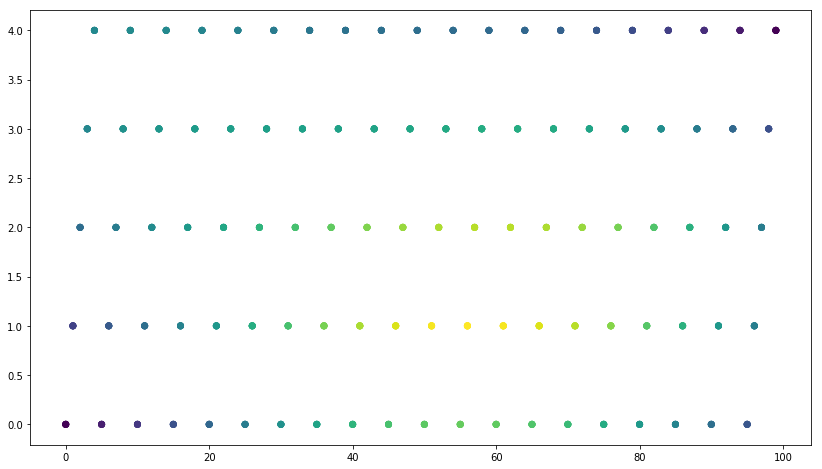

In [24]:
from scipy.stats import norm

plt.rcParams["figure.figsize"] = (14, 8)
def probability_of_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return norm.cdf(gamma_x)


def expected_improvement(mu_x, sigma_x, opt_value, kappa=0.5):
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return sigma_x * (gamma_x * norm.cdf(gamma_x) + norm.pdf(gamma_x))


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel

kernel = Matern(length_scale = [50,3],length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, alpha=s, random_state=0,normalize_y=False)
gp.fit(x, y)

N = [n for n in range(params['N_Max'])]
T = [t for t in range(params['T_Max'])]
A = [T[i] for j in range(len(N))for i in range(len(T))]
B = [N[i] for j in range(len(T))for i in range(len(N))]
T = np.asanyarray(A)
N = np.asanyarray(B)

X = np.zeros(shape=(T.shape[0],2))
X[:,0] = N
X[:,1] = T
y_pred,sigma = gp.predict(X,return_std=True)
print(y_pred.shape,sigma.shape)
# for t in range(T.max()+1):
#     t+=1
#     plt.figure()
#     plt.plot(X[(t-1)*N.shape[0]:t*N.shape[0],0],y_pred[(t-1)*N.shape[0]:t*N.shape[0]])
# #     print(y_pred[(t-1)*N.shape[0]:t*N.shape[0]])
#     plt.fill(np.concatenate([X[(t-1)*N.shape[0]:t*N.shape[0],0], (X[(t-1)*N.shape[0]:t*N.shape[0],0])[::-1]]),
#              np.concatenate([y_pred[(t-1)*N.shape[0]:t*N.shape[0]] - sigma[(t-1)*N.shape[0]:t*N.shape[0]],
#                              (y_pred[(t-1)*N.shape[0]:t*N.shape[0]] +  sigma[(t-1)*N.shape[0]:t*N.shape[0]])[::-1]]),
#              alpha=.2, fc='r', ec='None')
# plt.plot(X[:199,0],y_pred[:199])
# plt.plot(X[200:399,0],y_pred[200:399])
# plt.plot(X[400:599,0],y_pred[400:599])
# print(X[:200,0].shape,y_pred[:200].shape)
# plot(x, y, gp, filename="fig2.pdf")
# print(y_pred)
# print(y_pred.shape)
plt.figure()
plt.scatter(X[:,0],X[:,1],c=y_pred)
plt.legend()
Runs2 = Runs.copy()
# Y = y_pred.reshape(rpms.T_Max,rpms.N_Max)#[:,::-1]
# print(Y)
# # print(Y.shape)
# plt.figure()
# plt.imshow(Y[::-1])
# plt.colorbar()
# print(y_pred)



In [25]:
from scipy.optimize import minimize
acq = upper_confidence_bound
def query(xi, yi, gp):
    best_value = np.inf

    for N in np.linspace(1,params['N_Max']):
        for T in np.linspace(0,params['T_Max']):
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
#                 print(np.min(yi),np.max(yi))
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray([N,T]).reshape(1,2)
            res = minimize(obj, x0, bounds=((1, params['N_Max']),(0,params['T_Max'])))

            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point

for i in range(2):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=s, random_state=1,normalize_y=True)
    gp.fit(x, y)
    
    next_x = query(x, y, gp)
    print(next_x)
    N = int(np.round(next_x[0],0))
    T = int(np.round(next_x[1],0))
    o = 0
    while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
        print('Adjust!')
        o +=1
        N += int(o*np.cos(o*np.pi))
    print(N,T)
    d = {'N':N,'T':T,'MSE':0,'STD':0}
    idx = Runs.index[-1] + 1
    D2 = pd.DataFrame(data=d,index=[idx])
    Runs = Runs.append(D2)
    
    MSE = RunReps(Model,Runs,params,pool)#RunFunc(i,processes=processes,Modz=Model,reps=reps,epochs=epochs,params=Runs)
    print(MSE)
    Runs['MSE'][idx]=MSE.mean()
    Runs['STD'][idx]=MSE.std()
    
    Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    
    x = Runs[['N','T']].values
    y = Runs['MSE'].values
    s = Runs['STD'].values
    
print(Runs)

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

[ 62.46448686   5.        ]
62 5
[ 1.25058309  0.75735947]
[ 59.3343527    3.62913639]
59 4
[ 1.24821324  0.75735948]
         MSE   N       STD  T
0   0.810429   1  0.012334  4
1   0.766574  36  0.036785  4
2   0.838825  46  0.158889  3
3   1.152550  51  0.089458  1
4   0.878249  52  0.121124  3
5   1.132661  54  0.112002  1
6   1.003899  58  0.246540  0
7   0.978152  59  0.223253  0
8   1.002786  59  0.245427  4
9   0.741621  61  0.006187  4
10  1.003971  62  0.246612  5
11  1.033790  81  0.159665  2


In [26]:
print(Runs[Runs['MSE'] == Runs['MSE'].min()])

        MSE   N       STD  T
9  0.741621  61  0.006187  4


In [29]:
# print(Runs)
# print(x,y,s)
# print(next_x)
# print(int(np.round(next_x[1],0)))

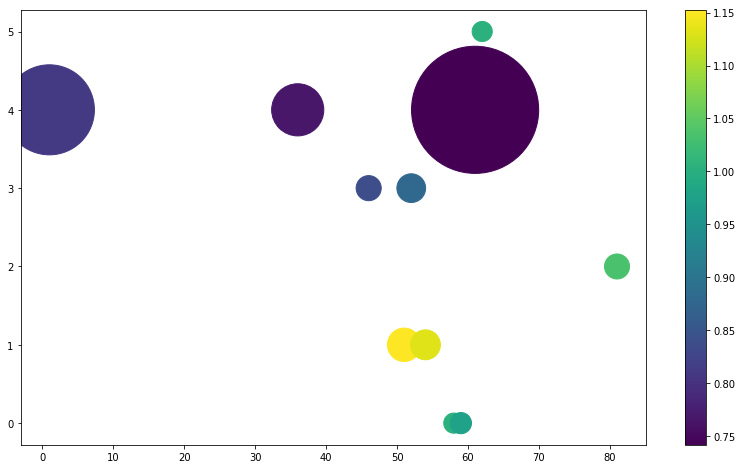

In [28]:

plt.figure()
plt.scatter(Runs["N"],Runs['T'],s=1/Runs['STD']*100,c=Runs['MSE'])
plt.colorbar()
# plt.legend()